# DonorsChoose

In [1]:
import dill

In [2]:
dill.load_session('9notebook_env.db')

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

## About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_3:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

In [3]:
# loading required libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn import model_selection

## 1.1 Reading Data

In [4]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [5]:
print("Number of data points in train data", project_data.shape)
print('-'*60)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
------------------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [6]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(project_data.columns)]

#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])  #used to convert into datetime object
project_data.drop('project_submitted_datetime', axis=1, inplace=True)
project_data.sort_values(by=['Date'], inplace=True)

# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]

project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
55660        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.   
76127       37728  p043609  3f60494c61921b3b43ab61bdde2904df            Ms.   

      school_state                Date project_grade_category  \
55660           CA 2016-04-27 00:27:36          Grades PreK-2   
76127           UT 2016-04-27 00:31:25             Grades 3-5   

      project_subject_categories            project_subject_subcategories  \
55660             Math & Science  Applied Sciences, Health & Life Science   
76127              Special Needs                            Special Needs   

                                      project_title  \
55660  Engineering STEAM into the Primary Classroom   
76127                       Sensory Tools for Focus   

                                         project_essay_1  \
55660  I have been fortunate enough to use the Fairy ...   
76127  Imagine being 8-9 years old. You're in your th...   

                                         project_essay_2  \
55660  My students come from a variety of backgrounds...   
76127  Most of my students have autism, anxiety, anot...   

                                         project_essay_3  \
55660  Each month I try to do several science or STEM...   
76127  It is tough to do more than one thing at a tim...   

                                         project_essay_4  \
55660  It is challenging to develop high quality scie...   
76127  When my students are able to calm themselves d...   

                                project_resource_summary  \
55660  My students need STEM kits to learn critical s...   
76127  My students need Boogie Boards for quiet senso...   

       teacher_number_of_previously_posted_projects  project_is_approved  
55660                                            53                    1  
76127                                             4                    1

In [7]:
print("Number of data points in resource train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in resource train data (1541272, 4)
['id' 'description' 'quantity' 'price']


id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

## 1.2 preprocessing of `project_subject_categories`

In [8]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


## 1.3 preprocessing of `project_subject_subcategories`

In [9]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

## 1.3 Text preprocessing

In [10]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)
project_data.drop(['project_essay_1','project_essay_2', 'project_essay_3', 'project_essay_4'], axis=1, inplace=True)

In [11]:
project_data.drop(['project_resource_summary'], axis=1, inplace=True)
project_data.head(1)

Unnamed: 0       id                        teacher_id teacher_prefix  \
55660        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.   

      school_state                Date project_grade_category  \
55660           CA 2016-04-27 00:27:36          Grades PreK-2   

                                      project_title  \
55660  Engineering STEAM into the Primary Classroom   

       teacher_number_of_previously_posted_projects  project_is_approved  \
55660                                            53                    1   

      clean_categories                 clean_subcategories  \
55660     Math_Science  AppliedSciences Health_LifeScience   

                                                   essay  
55660  I have been fortunate enough to use the Fairy ...

In [12]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [13]:
sent = decontracted(project_data['essay'].values[20000])
# print(sent)
# print("="*50)

In [14]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
# print(sent)

In [15]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
# print(sent)

In [16]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

<h2><font color='red'> 1.4.1 Preprocessing of `essays`</font></h2>

In [17]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|██████████| 109248/109248 [01:25<00:00, 1278.57it/s]


In [18]:
# after preprocesing we drop some coloums which we don't use from now on
project_data['preprocessed_essays'] = preprocessed_essays
project_data.drop(['essay'], axis=1, inplace=True)

project_data.head(1)

Unnamed: 0       id                        teacher_id teacher_prefix  \
55660        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.   

      school_state                Date project_grade_category  \
55660           CA 2016-04-27 00:27:36          Grades PreK-2   

                                      project_title  \
55660  Engineering STEAM into the Primary Classroom   

       teacher_number_of_previously_posted_projects  project_is_approved  \
55660                                            53                    1   

      clean_categories                 clean_subcategories  \
55660     Math_Science  AppliedSciences Health_LifeScience   

                                     preprocessed_essays  
55660  fortunate enough use fairy tale stem kits clas...

<h2><font color='red'> 1.4.2 Preprocessing of `project_title`</font></h2>

In [19]:
# preprocessing project titles
from tqdm import tqdm
preprocessed_titles = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_titles.append(sent.lower().strip())

100%|██████████| 109248/109248 [00:03<00:00, 32529.28it/s]


In [20]:
# droping coloums project_titles and project_resource_summary which we don't want to use
project_data['preprocessed_titles'] = preprocessed_titles
project_data.drop(['project_title'], axis=1, inplace=True)
project_data.head(1)

Unnamed: 0       id                        teacher_id teacher_prefix  \
55660        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.   

      school_state                Date project_grade_category  \
55660           CA 2016-04-27 00:27:36          Grades PreK-2   

       teacher_number_of_previously_posted_projects  project_is_approved  \
55660                                            53                    1   

      clean_categories                 clean_subcategories  \
55660     Math_Science  AppliedSciences Health_LifeScience   

                                     preprocessed_essays  \
55660  fortunate enough use fairy tale stem kits clas...   

                       preprocessed_titles  
55660  engineering steam primary classroom

### preprocessing of project_grade_category

In [21]:
# preprocessing of preoject_grade_category
from tqdm import tqdm
preprocessed_pgc = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_grade_category'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = '_'.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_pgc.append(sent.lower().strip())

100%|██████████| 109248/109248 [00:02<00:00, 40356.29it/s]


In [22]:
project_data['preprocessed_pgc'] = preprocessed_pgc
project_data.drop(['project_grade_category'], axis=1, inplace=True)

### preprocessing of teacher_prefix categorical feature

In [23]:
# preprocessing of teacher prefix
from tqdm import tqdm
preprocessed_tp = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['teacher_prefix'].values):
    sent = decontracted(str(sentance))
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = '_'.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_tp.append(sent.lower().strip())

100%|██████████| 109248/109248 [00:01<00:00, 58570.97it/s]


In [24]:
project_data['preprocessed_tp'] = preprocessed_tp
project_data.drop(['teacher_prefix'], axis=1, inplace=True)

In [25]:
# Merging Project_data and price data dataframe  
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')
project_data.head(2)

Unnamed: 0       id                        teacher_id school_state  \
0        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           CA   
1       37728  p043609  3f60494c61921b3b43ab61bdde2904df           UT   

                 Date  teacher_number_of_previously_posted_projects  \
0 2016-04-27 00:27:36                                            53   
1 2016-04-27 00:31:25                                             4   

   project_is_approved clean_categories                 clean_subcategories  \
0                    1     Math_Science  AppliedSciences Health_LifeScience   
1                    1     SpecialNeeds                        SpecialNeeds   

                                 preprocessed_essays  \
0  fortunate enough use fairy tale stem kits clas...   
1  imagine 8 9 years old third grade classroom se...   

                   preprocessed_titles preprocessed_pgc preprocessed_tp  \
0  engineering steam primary classroom    grades_prek_2             mrs   
1                  sensory tools focus       grades_3_5              ms   

    price  quantity  
0  725.05         4  
1  213.03         8

In [26]:
project_data['project_is_approved'].value_counts()

1    92706
0    16542
Name: project_is_approved, dtype: int64

Since Number of data points for which are project is approved is much greater than the number of data points for which project is not approved so this is imbalence dataset.

## 1.5 Preparing data for models

In [27]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'school_state', 'Date',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'preprocessed_essays',
       'preprocessed_titles', 'preprocessed_pgc', 'preprocessed_tp', 'price',
       'quantity'],
      dtype='object')

we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       
       - quantity : numerical
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

# Assignment 9: RF and GBDT

#### Response Coding: Example

<img src='response.JPG' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

<ol>
    <li><strong>Apply both Random Forrest and GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(BOW) + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)</li>
            <li><font color='red'>Set 3</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(AVG W2V)+  preprocessed_eassay (AVG W2V)</li>
            <li><font color='red'>Set 4</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters preferably n_estimators, max_depth)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You can choose either of the plotting techniques: 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
            </ul>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakage, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

<h1>2. Random Forest and GBDT </h1>

In [28]:
project_data.head(1)

Unnamed: 0       id                        teacher_id school_state  \
0        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           CA   

                 Date  teacher_number_of_previously_posted_projects  \
0 2016-04-27 00:27:36                                            53   

   project_is_approved clean_categories                 clean_subcategories  \
0                    1     Math_Science  AppliedSciences Health_LifeScience   

                                 preprocessed_essays  \
0  fortunate enough use fairy tale stem kits clas...   

                   preprocessed_titles preprocessed_pgc preprocessed_tp  \
0  engineering steam primary classroom    grades_prek_2             mrs   

    price  quantity  
0  725.05         4

In [29]:
y = project_data['project_is_approved'].values
X = project_data.drop(['project_is_approved'], axis=1)

<h2>2.1 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [30]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

In [31]:
print(X_train.shape)
print(y_train.shape)
print(X_cv.shape)
print(y_cv.shape)
print(X_test.shape)
print(y_test.shape)

(69918, 14)
(69918,)
(17480, 14)
(17480,)
(21850, 14)
(21850,)


<h2>2.2 Make Data Model Ready: encoding numerical, categorical features</h2>

In [72]:
# This function returns response table as described in above instructions.Response table is in form of dictionary 
# in which keys are unique values taken by that categorical feature and values are tuple which contain 
# first element as number of occurances for class 0 and second is of class 1.

def build_response_table(feature_values, classes):
    # Our final dictionary
    response_table = {}
    
    # getting all unique value of that feature (feature_values)
    all_unique_values = np.unique(feature_values)
    for val in all_unique_values:  # for all unique values of that feature
        
        # getting number of occurances for class 0
        num_zeros = np.sum((feature_values == val) & (classes == 0))
        
        # getting number of occurances for class 1
        num_ones = np.sum((feature_values == val) & (classes == 1))
        
        # insert above values in form of tuple for that unique categorical value  
        response_table[val] = (num_zeros, num_ones)
    
    # return our response table      
    return response_table

In [74]:
# This function builds encoded matrix for one categorical feature as descibed in above instructions
# this function takes list of categorical values for all data points as feature_values and response table as rt
def build_encoded_matrix(feature_values, rt):
    
    # Our final values encoded answer matrix
    encoded_matrix = []
    
    for val in feature_values:     # for every value in feature_values as val
        try:
            # insert probability score of this feature value val for class 0 and class 1 using response table rt
            encoded_matrix.append( [ rt[val][0] / sum(rt[val]),  rt[val][1] / sum(rt[val]) ])
        
        except KeyError:        # if that val not found in the rt 
            encoded_matrix.append([0.5, 0.5])
    
    #convert each value upto 3 decimal places and matrix in numpy arrays
    encoded_matrix = np.around(np.array(encoded_matrix), decimals = 2)
    return encoded_matrix

## 2.2.1 Response encoding the categorical features: school_state

- https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/

In [91]:
# response coding for training, cv and test data  
rt = build_response_table(X_train['school_state'].values, y_train) # fit has to happen only on train data


# we use response table rt to convert the text to vectors
X_train_state_ohe = build_encoded_matrix(X_train['school_state'].values, rt)
X_cv_state_ohe = build_encoded_matrix(X_cv['school_state'].values, rt)
X_test_state_ohe = build_encoded_matrix(X_test['school_state'].values, rt)

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_cv_state_ohe.shape, y_cv.shape)
print(X_test_state_ohe.shape, y_test.shape)

After vectorizations
(69918, 2) (69918,)
(17480, 2) (17480,)
(21850, 2) (21850,)


## 2.2.2 Response encoding the categorical features: clean_categories

In [92]:
# response coding for training, cv and test data  
rt = build_response_table(X_train['clean_categories'].values, y_train) # fit has to happen only on train data


# we use response table rt to convert the text to vectors
X_train_categories_ohe = build_encoded_matrix(X_train['clean_categories'].values, rt)
X_cv_categories_ohe = build_encoded_matrix(X_cv['clean_categories'].values, rt)
X_test_categories_ohe = build_encoded_matrix(X_test['clean_categories'].values, rt)

print("After vectorizations")
print(X_train_categories_ohe.shape, y_train.shape)
print(X_cv_categories_ohe.shape, y_cv.shape)
print(X_test_categories_ohe.shape, y_test.shape)

After vectorizations
(69918, 2) (69918,)
(17480, 2) (17480,)
(21850, 2) (21850,)


## 2.2.3 Response encoding the categorical features: clean_subcategories

In [93]:
# response coding for training, cv and test data  
rt = build_response_table(X_train['clean_subcategories'].values, y_train) # fit has to happen only on train data


# we use response table rt to convert the text to vectors
X_train_subcategories_ohe = build_encoded_matrix(X_train['clean_subcategories'].values, rt)
X_cv_subcategories_ohe = build_encoded_matrix(X_cv['clean_subcategories'].values, rt)
X_test_subcategories_ohe = build_encoded_matrix(X_test['clean_subcategories'].values, rt)

print("After vectorizations")
print(X_train_subcategories_ohe.shape, y_train.shape)
print(X_cv_subcategories_ohe.shape, y_cv.shape)
print(X_test_subcategories_ohe.shape, y_test.shape)

After vectorizations
(69918, 2) (69918,)
(17480, 2) (17480,)
(21850, 2) (21850,)


## 2.2.4 Response encoding the categorical features: teacher_prefix

In [95]:
# response coding for training, cv and test data  
rt = build_response_table(X_train['preprocessed_tp'].values, y_train) # fit has to happen only on train data


# we use response table rt to convert the text to vectors
X_train_teacher_prefix_ohe = build_encoded_matrix(X_train['preprocessed_tp'].values, rt)
X_cv_teacher_prefix_ohe = build_encoded_matrix(X_cv['preprocessed_tp'].values, rt)
X_test_teacher_prefix_ohe = build_encoded_matrix(X_test['preprocessed_tp'].values, rt)


print("After vectorizations")
print(X_train_teacher_prefix_ohe.shape, y_train.shape)
print(X_cv_teacher_prefix_ohe.shape, y_cv.shape)
print(X_test_teacher_prefix_ohe.shape, y_test.shape)

After vectorizations
(69918, 2) (69918,)
(17480, 2) (17480,)
(21850, 2) (21850,)


## 2.2.5 Response encoding the categorical features: project_grade_category

In [96]:
# response coding for training, cv and test data  
rt = build_response_table(X_train['preprocessed_pgc'].values, y_train) # fit has to happen only on train data


# we use response table rt to convert the text to vectors
X_train_pgc_ohe = build_encoded_matrix(X_train['preprocessed_pgc'].values, rt)
X_cv_pgc_ohe = build_encoded_matrix(X_cv['preprocessed_pgc'].values, rt)
X_test_pgc_ohe = build_encoded_matrix(X_test['preprocessed_pgc'].values, rt)

print("After vectorizations")
print(X_train_pgc_ohe.shape, y_train.shape)
print(X_cv_pgc_ohe.shape, y_cv.shape)
print(X_test_pgc_ohe.shape, y_test.shape)

After vectorizations
(69918, 2) (69918,)
(17480, 2) (17480,)
(21850, 2) (21850,)


## 2.2.6 Normalizing the numerical features: Price

In [98]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)

After vectorizations
(69918, 1) (69918,)
(17480, 1) (17480,)
(21850, 1) (21850,)


## 2.2.7 Normalizing the numerical features: teacher_number_of_previously_posted_projects

In [99]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_tnppp_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_tnppp_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_tnppp_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_tnppp_norm.shape, y_train.shape)
print(X_cv_tnppp_norm.shape, y_cv.shape)
print(X_test_tnppp_norm.shape, y_test.shape)

After vectorizations
(69918, 1) (69918,)
(17480, 1) (17480,)
(21850, 1) (21850,)


## 2.2.8 Normalizing the numerical features: quantity

In [100]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['quantity'].values.reshape(-1,1))

X_train_quantity_norm = normalizer.transform(X_train['quantity'].values.reshape(-1,1))
X_cv_quantity_norm = normalizer.transform(X_cv['quantity'].values.reshape(-1,1))
X_test_quantity_norm = normalizer.transform(X_test['quantity'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_quantity_norm.shape, y_train.shape)
print(X_cv_quantity_norm.shape, y_cv.shape)
print(X_test_quantity_norm.shape, y_test.shape)

After vectorizations
(69918, 1) (69918,)
(17480, 1) (17480,)
(21850, 1) (21850,)


<h2>2.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [101]:
X_train.head(2)

Unnamed: 0       id                        teacher_id school_state  \
13099      107736  p035547  7270dd20e2612882c62a0d6b856f6ad6           NY   
64267      177734  p240193  b55d6b6266fd326f433aabc091f4b4e5           MI   

                     Date  teacher_number_of_previously_posted_projects  \
13099 2016-07-07 17:33:49                                            47   
64267 2016-11-03 21:16:58                                             2   

                     clean_categories              clean_subcategories  \
13099  Literacy_Language SpecialNeeds  Literature_Writing SpecialNeeds   
64267               Literacy_Language                         Literacy   

                                     preprocessed_essays preprocessed_titles  \
13099  special education teacher high need area new y...     ready set learn   
64267  reading center everything 7th grade ela classr...    reading everyone   

      preprocessed_pgc preprocessed_tp   price  quantity  
13099    grades_prek_2             mrs  348.93        15  
64267       grades_6_8             mrs   69.99         6

#### Bag of words for essays

In [105]:
# We are considering only the words which appeared in at least 10 documents(rows or projects)
vectorizer = CountVectorizer(min_df=10, max_features=5000)
vectorizer.fit(X_train['preprocessed_essays'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer.transform(X_train['preprocessed_essays'].values)
X_cv_essay_bow = vectorizer.transform(X_cv['preprocessed_essays'].values)
X_test_essay_bow = vectorizer.transform(X_test['preprocessed_essays'].values)

print("After vectorizations")
print(X_train_essay_bow.shape, y_train.shape)
print(X_cv_essay_bow.shape, y_cv.shape)
print(X_test_essay_bow.shape, y_test.shape)

After vectorizations
(69918, 5000) (69918,)
(17480, 5000) (17480,)
(21850, 5000) (21850,)


#### Bag of words for titles

In [106]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=10)
vectorizer.fit(X_train['preprocessed_titles'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_title_bow = vectorizer.transform(X_train['preprocessed_titles'].values)
X_cv_title_bow = vectorizer.transform(X_cv['preprocessed_titles'].values)
X_test_title_bow = vectorizer.transform(X_test['preprocessed_titles'].values)

print("After vectorizations")
print(X_train_title_bow.shape, y_train.shape)
print(X_cv_title_bow.shape, y_cv.shape)
print(X_test_title_bow.shape, y_test.shape)

After vectorizations
(69918, 2453) (69918,)
(17480, 2453) (17480,)
(21850, 2453) (21850,)


#### TFIDF vectorizer for essays

In [107]:
# tfidf vectorizer on project essays
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10,  max_features=5000)
vectorizer.fit(X_train['preprocessed_essays'].values)


# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer.transform(X_train['preprocessed_essays'].values)
X_cv_essay_tfidf = vectorizer.transform(X_cv['preprocessed_essays'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['preprocessed_essays'].values)

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_cv_essay_tfidf.shape, y_cv.shape)
print(X_test_essay_tfidf.shape, y_test.shape)

After vectorizations
(69918, 5000) (69918,)
(17480, 5000) (17480,)
(21850, 5000) (21850,)


#### TFIDF vectorizer for titles

In [108]:
# tfidf vectorizer on project titles
vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(X_train['preprocessed_titles'].values)


# we use the fitted CountVectorizer to convert the text to vector
X_train_title_tfidf = vectorizer.transform(X_train['preprocessed_titles'].values)
X_cv_title_tfidf = vectorizer.transform(X_cv['preprocessed_titles'].values)
X_test_title_tfidf = vectorizer.transform(X_test['preprocessed_titles'].values)

print("After vectorizations")
print(X_train_title_tfidf.shape, y_train.shape)
print(X_cv_title_tfidf.shape, y_cv.shape)
print(X_test_title_tfidf.shape, y_test.shape)

After vectorizations
(69918, 2453) (69918,)
(17480, 2453) (17480,)
(21850, 2453) (21850,)


#### Using Pretrained Models: Avg W2V for essays

In [109]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [110]:
def convert_avg_w2v(temp_list_essay):
    # average Word2Vec for preprocessed essays
    # compute average word2vec for each review.
    text_avg_w2v = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(temp_list_essay): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        cnt_words = 0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if word in glove_words:
                vector += model[word]
                cnt_words += 1
        if cnt_words != 0:
            vector /= cnt_words
        text_avg_w2v.append(vector)
    return text_avg_w2v


In [111]:
X_train_essay_avgw2v = convert_avg_w2v(X_train['preprocessed_essays'].values)
X_cv_essay_avgw2v = convert_avg_w2v(X_cv['preprocessed_essays'].values)
X_test_essay_avgw2v = convert_avg_w2v(X_test['preprocessed_essays'].values)

print("After vectorizations")
print(len(X_train_essay_avgw2v), y_train.shape)
print(len(X_cv_essay_avgw2v), y_cv.shape)
print(len(X_test_essay_avgw2v), y_test.shape)

100%|██████████| 21850/21850 [00:08<00:00, 2643.10it/s]

After vectorizations
69918 (69918,)
17480 (17480,)
21850 (21850,)


#### Using Pretrained Models: Avg W2V for titles

In [112]:
# average Word2Vec for preprocessed titles
X_train_title_avgw2v = convert_avg_w2v(X_train['preprocessed_titles'].values)
X_cv_title_avgw2v = convert_avg_w2v(X_cv['preprocessed_titles'].values)
X_test_title_avgw2v = convert_avg_w2v(X_test['preprocessed_titles'].values)

print("After vectorizations")
print(len(X_train_title_avgw2v), y_train.shape)
print(len(X_cv_title_avgw2v), y_cv.shape)
print(len(X_test_title_avgw2v), y_test.shape)
print(len(X_train_title_avgw2v[0]))
print(len(X_cv_title_avgw2v[0]))
print(len(X_test_title_avgw2v[0]))

100%|██████████| 21850/21850 [00:00<00:00, 45698.36it/s]

After vectorizations
69918 (69918,)
17480 (17480,)
21850 (21850,)
300
300
300


#### Using Pretrained Models: TFIDF weighted W2V for essays

In [113]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['preprocessed_essays'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [114]:
def convert_tfidf_w_w2v(temp_list_essay):
    # tfidf weighted Word2Vec
    # compute tfidf weighted word2vec for each review.
    text_tfidf_w_w2v = []; # the tfid weighted w2v for each sentence/review is stored in this list
    for sentence in tqdm(temp_list_essay): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        text_tfidf_w_w2v.append(vector)
    return text_tfidf_w_w2v

In [115]:
X_train_essay_tww2v = convert_tfidf_w_w2v(X_train['preprocessed_essays'].values)
X_cv_essay_tww2v = convert_tfidf_w_w2v(X_cv['preprocessed_essays'].values)
X_test_essay_tww2v = convert_tfidf_w_w2v(X_test['preprocessed_essays'].values)

print("After vectorizations")
print(len(X_train_essay_tww2v), y_train.shape)
print(len(X_cv_essay_tww2v), y_cv.shape)
print(len(X_test_essay_tww2v), y_test.shape)

100%|██████████| 21850/21850 [00:54<00:00, 516.10it/s]

After vectorizations
69918 (69918,)
17480 (17480,)
21850 (21850,)


#### Using Pretrained Models: TFIDF weighted W2V for titles

In [116]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['preprocessed_titles'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [117]:
X_train_titles_tww2v = convert_tfidf_w_w2v(X_train['preprocessed_titles'].values)
X_cv_titles_tww2v = convert_tfidf_w_w2v(X_cv['preprocessed_titles'].values)
X_test_titles_tww2v = convert_tfidf_w_w2v(X_test['preprocessed_titles'].values)

print("After vectorizations")
print(len(X_train_titles_tww2v), y_train.shape)
print(len(X_cv_titles_tww2v), y_cv.shape)
print(len(X_test_titles_tww2v), y_test.shape)

100%|██████████| 21850/21850 [00:00<00:00, 26872.11it/s]

After vectorizations
69918 (69918,)
17480 (17480,)
21850 (21850,)


<h2>2.4 Applying Random Forest</h2>

<br>Apply Random Forest on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

### 2.4.1 Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [87]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_bow, X_train_title_bow, X_train_state_ohe, X_train_categories_ohe, X_train_subcategories_ohe, X_train_teacher_prefix_ohe, X_train_pgc_ohe, X_train_price_norm, X_train_tnppp_norm)).tocsr()
X_cr = hstack((X_cv_essay_bow, X_cv_title_bow, X_cv_state_ohe, X_cv_categories_ohe, X_cv_subcategories_ohe, X_cv_teacher_prefix_ohe, X_cv_pgc_ohe, X_cv_price_norm, X_cv_tnppp_norm)).tocsr()
X_te = hstack((X_test_essay_bow, X_test_title_bow, X_test_state_ohe, X_test_categories_ohe, X_test_subcategories_ohe, X_test_teacher_prefix_ohe, X_test_pgc_ohe, X_test_price_norm, X_test_tnppp_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(69918, 7465) (69918,)
(17480, 7465) (17480,)
(21850, 7465) (21850,)


In [88]:
%matplotlib inline

In [134]:
# importing required libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import numpy as np

# our hyperparameters to choose from
depth = [5, 10, 50, 100, 500]
n_estimators = [30, 60, 100, 200, 300]
param_grid = dict(max_depth = depth, n_estimators = n_estimators)

clf_ = RandomForestClassifier(n_jobs=-1, class_weight = 'balanced')

clf = GridSearchCV(clf_, param_grid, scoring = 'roc_auc', cv=3, n_jobs=-1)

sc = clf.fit(X_tr, y_train)

# getting all the results
scores = clf.cv_results_
# getting train scores and cross validation scores
train_score = scores['mean_train_score']
cv_score = scores['mean_test_score']
 
# Reshape matrix for printing out in heatmap
train_score_reshaped = train_score.reshape(len(depth), len(n_estimators))
cv_score_reshaped = cv_score.reshape(len(depth), len(n_estimators))

Text(0.5, 1, 'Heatmap AUC scores for training data ')

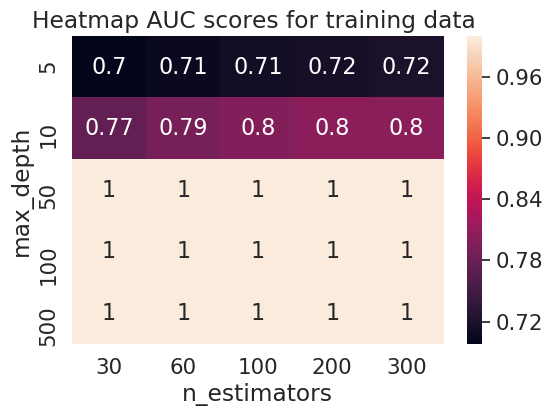

In [169]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
  
df_cm = pd.DataFrame(train_score_reshaped, depth, n_estimators)
plt.figure(figsize = (6, 4))
sn.set(font_scale = 1.4) #for label size
df_cm.index.name = 'max_depth'
df_cm.columns.name = 'n_estimators'
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2g')# font size
plt.title("Heatmap AUC scores for training data ")

Text(0.5, 1, 'Heatmap AUC scores for cross validation data')

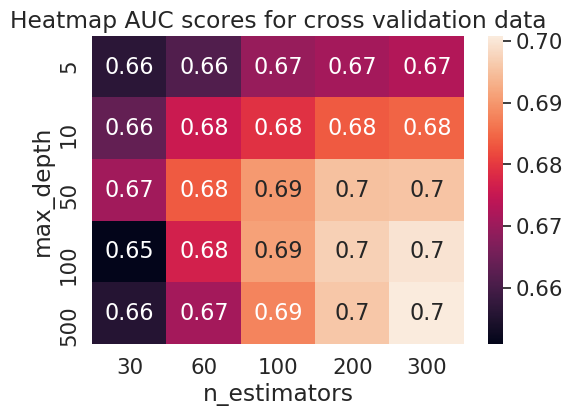

In [170]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
  
df_cm = pd.DataFrame(cv_score_reshaped, depth, n_estimators)
plt.figure(figsize = (6, 4))
sn.set(font_scale = 1.4) #for label size
df_cm.index.name = 'max_depth'
df_cm.columns.name = 'n_estimators'
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2g')# font size
plt.title("Heatmap AUC scores for cross validation data")

#### Training our final RandomForest model on max_depth = 5 with n_estimaters = 200

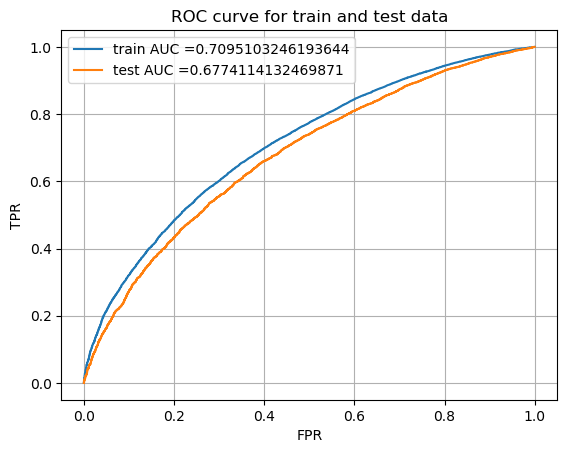

In [91]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(class_weight='balanced', max_depth = 5, n_estimators =200,n_jobs=-1)

clf.fit(X_tr, y_train)

y_train_pred = clf.predict_proba(X_tr)[:,1]
y_test_pred = clf.predict_proba(X_te)[:,1]


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for train and test data")
plt.grid()
plt.show()

Here train AUC is higher than the test auc that means this model is overfitting on the train data.

##### Drawing confusion matrix

In [92]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
# this function returns actual prediction in form of 0 and 1 by accepting the probability score on the data
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [93]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
cmtr = confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr))
print("Test confusion matrix")
cmte = confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.42604707168025396 for threshold 0.499
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.39812560901314015 for threshold 0.516


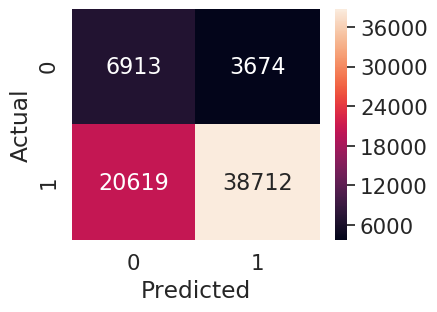

In [94]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
array = cmtr       
df_cm = pd.DataFrame(array, range(2), range(2))
plt.figure(figsize = (4,3))
sn.set(font_scale = 1.4) #for label size
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')# font size
plt.show()

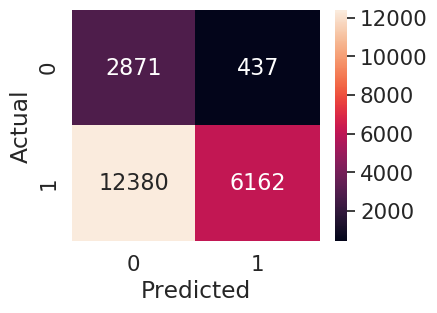

In [95]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = cmte       
df_cm = pd.DataFrame(array, range(2),range(2))
plt.figure(figsize = (4,3))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sn.set(font_scale=1.4) #for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
plt.show()

### 2.4.2 Applying Random Forests on TF-IDF,<font color='red'> SET 2</font>

In [14]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_tfidf, X_train_title_tfidf, X_train_state_ohe, X_train_categories_ohe, X_train_subcategories_ohe, X_train_teacher_prefix_ohe, X_train_pgc_ohe, X_train_price_norm, X_train_tnppp_norm)).tocsr()
X_cr = hstack((X_cv_essay_tfidf, X_cv_title_tfidf, X_cv_state_ohe, X_cv_categories_ohe, X_cv_subcategories_ohe, X_cv_teacher_prefix_ohe, X_cv_pgc_ohe, X_cv_price_norm, X_cv_tnppp_norm)).tocsr()
X_te = hstack((X_test_essay_tfidf, X_test_title_tfidf, X_test_state_ohe, X_test_categories_ohe, X_test_subcategories_ohe, X_test_teacher_prefix_ohe, X_test_pgc_ohe, X_test_price_norm, X_test_tnppp_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(69918, 7465) (69918,)
(17480, 7465) (17480,)
(21850, 7465) (21850,)


In [183]:
# importing required libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import numpy as np

# our hyperparameters to choose from
depth = [5, 10, 30, 50, 100, 500]
n_estimators = [30, 60, 100, 200, 300, 400]
param_grid = dict(max_depth = depth, n_estimators = n_estimators)

clf_ = RandomForestClassifier(n_jobs=-1, class_weight = 'balanced')

clf = GridSearchCV(clf_, param_grid, scoring = 'roc_auc', cv=3, n_jobs=-1)

sc = clf.fit(X_tr, y_train)

# getting all the results
scores = clf.cv_results_
# getting train scores and cross validation scores
train_score = scores['mean_train_score']
cv_score = scores['mean_test_score']
 
# Reshape matrix for printing out in heatmap
train_score_reshaped = train_score.reshape(len(depth), len(n_estimators))
cv_score_reshaped = cv_score.reshape(len(depth), len(n_estimators))

Text(0.5, 1, 'Heatmap AUC scores for training data ')

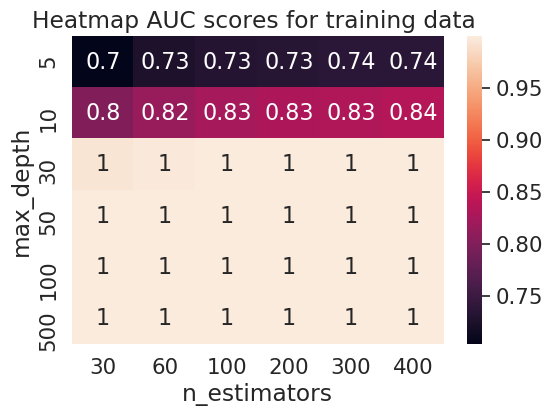

In [185]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
  
df_cm = pd.DataFrame(train_score_reshaped, depth, n_estimators)
plt.figure(figsize = (6, 4))
sn.set(font_scale = 1.4) #for label size
df_cm.index.name = 'max_depth'
df_cm.columns.name = 'n_estimators'
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2g')# font size
plt.title("Heatmap AUC scores for training data ")

Text(0.5, 1, 'Heatmap AUC scores for cross validation data')

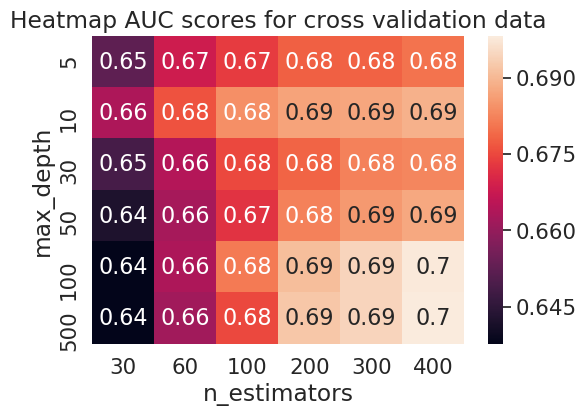

In [186]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
  
df_cm = pd.DataFrame(cv_score_reshaped, depth, n_estimators)
plt.figure(figsize = (6, 4))
sn.set(font_scale = 1.4) #for label size
df_cm.index.name = 'max_depth'
df_cm.columns.name = 'n_estimators'
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2g')# font size
plt.title("Heatmap AUC scores for cross validation data")

#### Training our final RandomForest model on max_depth = 5 with n_estimaters = 60.

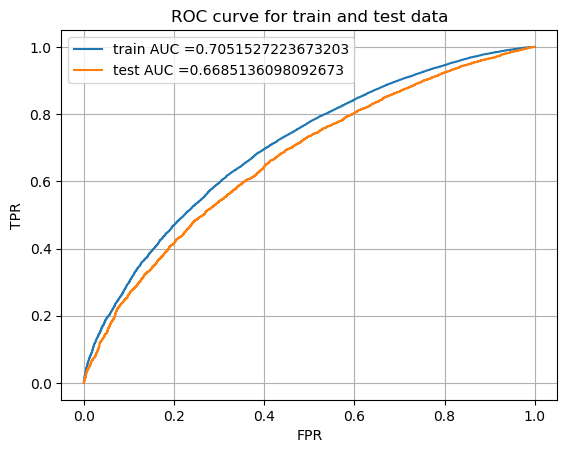

In [19]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(class_weight='balanced', max_depth = 5, n_estimators = 60,n_jobs=-1)

clf.fit(X_tr, y_train)

y_train_pred = clf.predict_proba(X_tr)[:,1]
y_test_pred = clf.predict_proba(X_te)[:,1]


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for train and test data")
plt.grid()
plt.show()

##### Drawing confusion matrix

In [20]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
# this function returns actual prediction in form of 0 and 1 by accepting the probability score on the data
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [21]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
cmtr = confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr))
print("Test confusion matrix")
cmte = confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.4216398664192042 for threshold 0.502
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.38823928211868947 for threshold 0.521


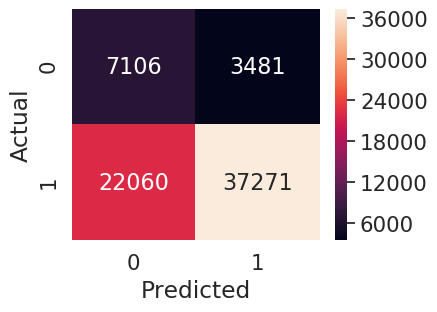

In [22]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = cmtr       
df_cm = pd.DataFrame(array, range(2),range(2))
plt.figure(figsize = (4,3))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sn.set(font_scale=1.4) #for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
plt.show()

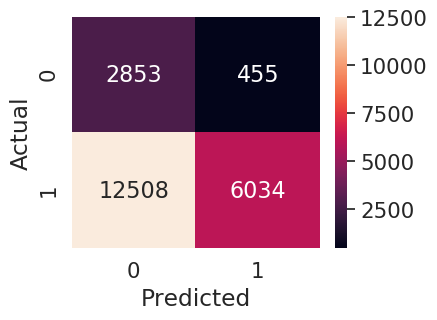

In [23]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = cmte       
df_cm = pd.DataFrame(array, range(2),range(2))
plt.figure(figsize = (4,3))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sn.set(font_scale=1.4) #for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
plt.show()

In [24]:
# converting list to sparse matrix
from scipy import sparse
X_train_essay_avgw2v = sparse.csr_matrix(X_train_essay_avgw2v)
X_train_title_avgw2v = sparse.csr_matrix(X_train_title_avgw2v)

X_cv_essay_avgw2v = sparse.csr_matrix(X_cv_essay_avgw2v)
X_cv_title_avgw2v = sparse.csr_matrix(X_cv_title_avgw2v)

X_test_essay_avgw2v = sparse.csr_matrix(X_test_essay_avgw2v)
X_test_title_avgw2v = sparse.csr_matrix(X_test_title_avgw2v)

### 2.4.3 Applying Random Forests on AVG w2v,<font color='red'> SET 3</font>

In [25]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_avgw2v, X_train_title_avgw2v, X_train_state_ohe, X_train_categories_ohe, X_train_subcategories_ohe, X_train_teacher_prefix_ohe, X_train_pgc_ohe, X_train_price_norm, X_train_tnppp_norm)).tocsr()
X_cr = hstack((X_cv_essay_avgw2v, X_cv_title_avgw2v, X_cv_state_ohe, X_cv_categories_ohe, X_cv_subcategories_ohe, X_cv_teacher_prefix_ohe, X_cv_pgc_ohe, X_cv_price_norm, X_cv_tnppp_norm)).tocsr()
X_te = hstack((X_test_essay_avgw2v, X_test_title_avgw2v, X_test_state_ohe, X_test_categories_ohe, X_test_subcategories_ohe, X_test_teacher_prefix_ohe, X_test_pgc_ohe, X_test_price_norm, X_test_tnppp_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(69918, 612) (69918,)
(17480, 612) (17480,)
(21850, 612) (21850,)


In [7]:
# importing required libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import numpy as np

# our hyperparameters to choose from
depth = [10, 30, 50, 100, 500]
n_estimators = [30, 60, 100, 200, 300]
param_grid = dict(max_depth = depth, n_estimators = n_estimators)

clf_ = RandomForestClassifier(n_jobs = -1)

clf = GridSearchCV(clf_, param_grid, scoring = 'roc_auc', cv=3, n_jobs=-1, return_train_score=True)


#Since hyperparameter tunning on complete train data takes too long time so we are using cross validation data
# for hyperparameter tuning. Gridsearchcv automatically devide this into train and cross validate data. 
sc = clf.fit(X_cr, y_cv)

# getting all the results
scores = clf.cv_results_
# getting train scores and cross validation scores
train_score = scores['mean_train_score']
cv_score = scores['mean_test_score']
 
# Reshape matrix for printing out in heatmap
train_score_reshaped = train_score.reshape(len(depth), len(n_estimators))
cv_score_reshaped = cv_score.reshape(len(depth), len(n_estimators))

/home/ashish/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Text(0.5, 1, 'Heatmap AUC scores for training data ')

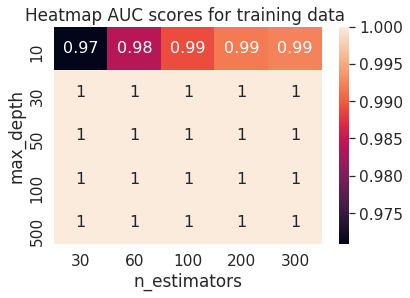

In [8]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
  
df_cm = pd.DataFrame(train_score_reshaped, depth, n_estimators)
plt.figure(figsize = (6, 4))
sn.set(font_scale = 1.4) #for label size
df_cm.index.name = 'max_depth'
df_cm.columns.name = 'n_estimators'
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2g')# font size
plt.title("Heatmap AUC scores for training data ")

Text(0.5, 1, 'Heatmap AUC scores for cross validation data')

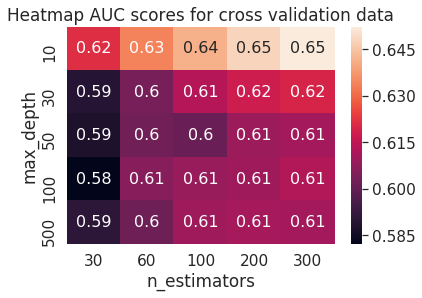

In [9]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
  
df_cm = pd.DataFrame(cv_score_reshaped, depth, n_estimators)
plt.figure(figsize = (6, 4))
sn.set(font_scale = 1.4) #for label size
df_cm.index.name = 'max_depth'
df_cm.columns.name = 'n_estimators'
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2g')# font size
plt.title("Heatmap AUC scores for cross validation data")

#### Training our final RandomForest model on max_depth = 5 with n_estimaters = 50.

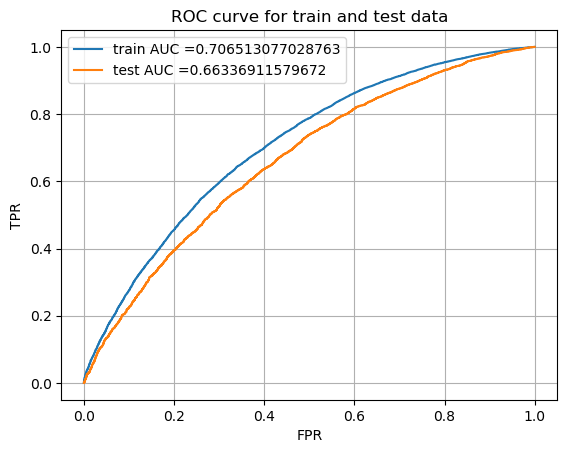

In [32]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(class_weight='balanced', max_depth = 5, n_estimators = 50, n_jobs = -1)

clf.fit(X_tr, y_train)

y_train_pred = clf.predict_proba(X_tr)[:,1]
y_test_pred = clf.predict_proba(X_te)[:,1]


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for train and test data")
plt.grid()
plt.show()

##### Drawing confusion matrix

In [33]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
# this function returns actual prediction in form of 0 and 1 by accepting the probability score on the data
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [34]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
cmtr = confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr))
print("Test confusion matrix")
cmte = confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.42508240996872376 for threshold 0.506
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.3831774381426552 for threshold 0.555


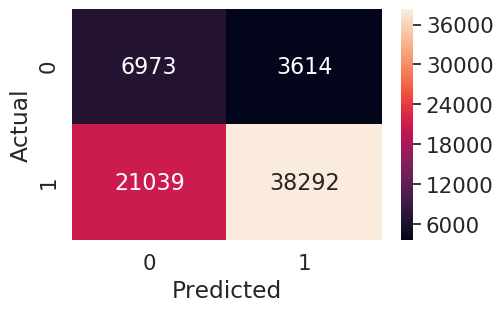

In [35]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
array = cmtr       
df_cm = pd.DataFrame(array, range(2),range(2))
plt.figure(figsize = (5,3))
sn.set(font_scale=1.4) #for label size
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
plt.show()

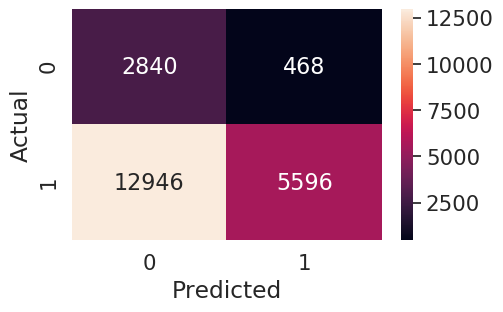

In [36]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
array = cmte       
df_cm = pd.DataFrame(array, range(2),range(2))
plt.figure(figsize = (5,3))
sn.set(font_scale=1.4) #for label size
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
plt.show()

In [37]:
# converting list to sparse matrix
from scipy import sparse
X_train_essay_tww2v = sparse.csr_matrix(X_train_essay_tww2v)
X_train_titles_tww2v = sparse.csr_matrix(X_train_titles_tww2v)

X_cv_essay_tww2v = sparse.csr_matrix(X_cv_essay_tww2v)
X_cv_titles_tww2v = sparse.csr_matrix(X_cv_titles_tww2v)

X_test_essay_tww2v = sparse.csr_matrix(X_test_essay_tww2v)
X_test_titles_tww2v = sparse.csr_matrix(X_test_titles_tww2v)

### 2.4.4 Applying Random Forests on TFIDF w2v,<font color='red'> SET 4</font>

In [38]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_tww2v, X_train_titles_tww2v, X_train_state_ohe, X_train_categories_ohe, X_train_subcategories_ohe, X_train_teacher_prefix_ohe, X_train_pgc_ohe, X_train_price_norm, X_train_tnppp_norm)).tocsr()
X_cr = hstack((X_cv_essay_tww2v, X_cv_titles_tww2v, X_cv_state_ohe, X_cv_categories_ohe, X_cv_subcategories_ohe, X_cv_teacher_prefix_ohe, X_cv_pgc_ohe, X_cv_price_norm, X_cv_tnppp_norm)).tocsr()
X_te = hstack((X_test_essay_tww2v, X_test_titles_tww2v, X_test_state_ohe, X_test_categories_ohe, X_test_subcategories_ohe, X_test_teacher_prefix_ohe, X_test_pgc_ohe, X_test_price_norm, X_test_tnppp_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(69918, 612) (69918,)
(17480, 612) (17480,)
(21850, 612) (21850,)


In [142]:
# importing required libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import numpy as np

# our hyperparameters to choose from
depth = [5, 10, 30, 50, 100, 200]
n_estimators = [30, 60, 100, 200, 300]
param_grid = dict(max_depth = depth, n_estimators = n_estimators)

clf_ = RandomForestClassifier(n_jobs = -1)

clf = GridSearchCV(clf_, param_grid, scoring = 'roc_auc', cv=3, n_jobs = -1, return_train_score=True)

#Since hyperparameter tunning on complete train data takes too long time so we are using cross validation data
# for hyperparameter tuning. Gridsearchcv automatically devide this into train and cross validate data. 
sc = clf.fit(X_cr, y_cv)

# getting all the results
scores = clf.cv_results_
# getting train scores and cross validation scores
train_score = scores['mean_train_score']
cv_score = scores['mean_test_score']
 
# Reshape matrix for printing out in heatmap
train_score_reshaped = train_score.reshape(len(depth), len(n_estimators))
cv_score_reshaped = cv_score.reshape(len(depth), len(n_estimators))

Text(0.5, 1, 'Heatmap AUC scores for training data ')

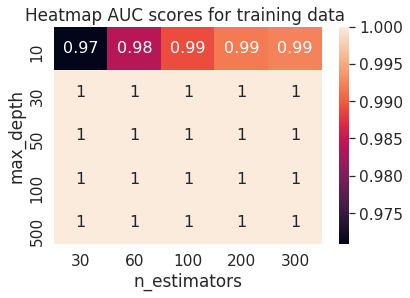

In [8]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
  
df_cm = pd.DataFrame(train_score_reshaped, depth, n_estimators)
plt.figure(figsize = (6, 4))
sn.set(font_scale = 1.4) #for label size
df_cm.index.name = 'max_depth'
df_cm.columns.name = 'n_estimators'
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2g')# font size
plt.title("Heatmap AUC scores for training data ")

Text(0.5, 1, 'Heatmap AUC scores for cross validation data')

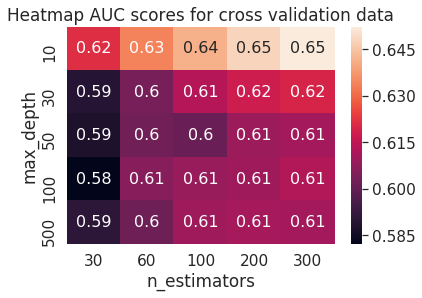

In [9]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
  
df_cm = pd.DataFrame(cv_score_reshaped, depth, n_estimators)
plt.figure(figsize = (6, 4))
sn.set(font_scale = 1.4) #for label size
df_cm.index.name = 'max_depth'
df_cm.columns.name = 'n_estimators'
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2g')# font size
plt.title("Heatmap AUC scores for cross validation data")

#### Training our final RandomForest model on max_depth = 3 with n_estimaters = 60 since we get highest AUC as 0.65 for these. 

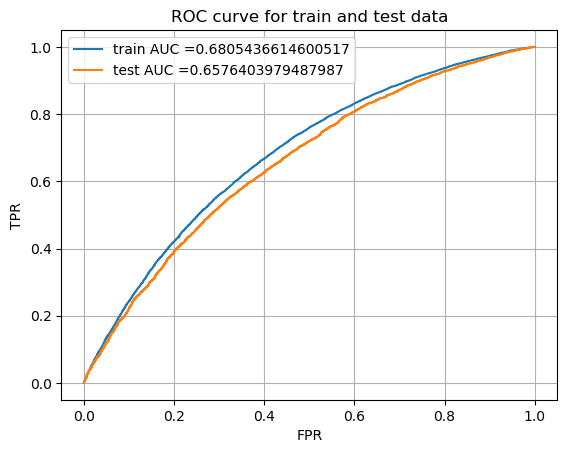

In [42]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth = 3, n_estimators = 60, n_jobs = -1)

clf.fit(X_tr, y_train)

y_train_pred = clf.predict_proba(X_tr)[:,1]
y_test_pred = clf.predict_proba(X_te)[:,1]


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for train and test data")
plt.grid()
plt.show()

##### Drawing confusion matrix

In [43]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
# this function returns actual prediction in form of 0 and 1 by accepting the probability score on the data
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [44]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
cmtr = confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr))
print("Test confusion matrix")
cmte = confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.4019019841771949 for threshold 0.841
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.37828593198721244 for threshold 0.866


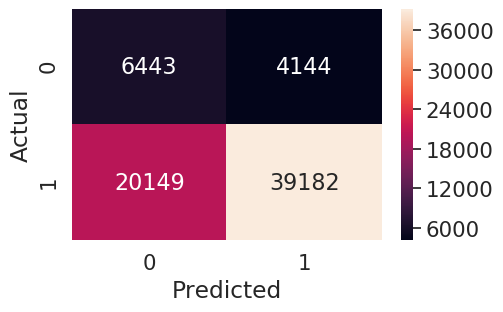

In [45]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
array = cmtr       
df_cm = pd.DataFrame(array, range(2),range(2))
plt.figure(figsize = (5,3))
sn.set(font_scale=1.4) #for label size
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
plt.show()

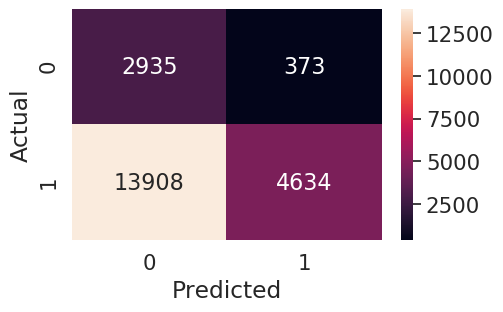

In [46]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
array = cmte       
df_cm = pd.DataFrame(array, range(2),range(2))
plt.figure(figsize = (5,3))
sn.set(font_scale=1.4) #for label size
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
plt.show()

<h2>2.5 Applying GBDT</h2>

<br>Apply GBDT on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

### 2.5.1 Applying XGBOOST on BOW,<font color='red'> SET 1</font>

In [47]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_bow, X_train_title_bow, X_train_state_ohe, X_train_categories_ohe, X_train_subcategories_ohe, X_train_teacher_prefix_ohe, X_train_pgc_ohe, X_train_price_norm, X_train_tnppp_norm)).tocsr()
X_cr = hstack((X_cv_essay_bow, X_cv_title_bow, X_cv_state_ohe, X_cv_categories_ohe, X_cv_subcategories_ohe, X_cv_teacher_prefix_ohe, X_cv_pgc_ohe, X_cv_price_norm, X_cv_tnppp_norm)).tocsr()
X_te = hstack((X_test_essay_bow, X_test_title_bow, X_test_state_ohe, X_test_categories_ohe, X_test_subcategories_ohe, X_test_teacher_prefix_ohe, X_test_pgc_ohe, X_test_price_norm, X_test_tnppp_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(69918, 7465) (69918,)
(17480, 7465) (17480,)
(21850, 7465) (21850,)


In [19]:
# importing required libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import seaborn as sns
import numpy as np

# our hyperparameters to choose from
depth = [5, 10, 30, 50, 100, 200]
n_estimators = [30, 60, 100, 200, 300]
param_grid = dict(max_depth = depth, n_estimators = n_estimators)

xgb_model = xgb.XGBClassifier(random_state=42, n_jobs=3)

clf = GridSearchCV(xgb_model, param_grid, scoring = 'roc_auc', cv=3, n_jobs = -1, return_train_score=True)

#Since hyperparameter tunning on complete train data takes too long time so we are using cross validation data
# for hyperparameter tuning. Gridsearchcv automatically devide this into train and cross validate data. 
sc = clf.fit(X_cr, y_cv)

# getting all the results
scores = clf.cv_results_
# getting train scores and cross validation scores
train_score = scores['mean_train_score']
cv_score = scores['mean_test_score']
 
# Reshape matrix for printing out in heatmap
train_score_reshaped = train_score.reshape(len(depth), len(n_estimators))
cv_score_reshaped = cv_score.reshape(len(depth), len(n_estimators))

Text(0.5, 1, 'Heatmap AUC scores for training data ')

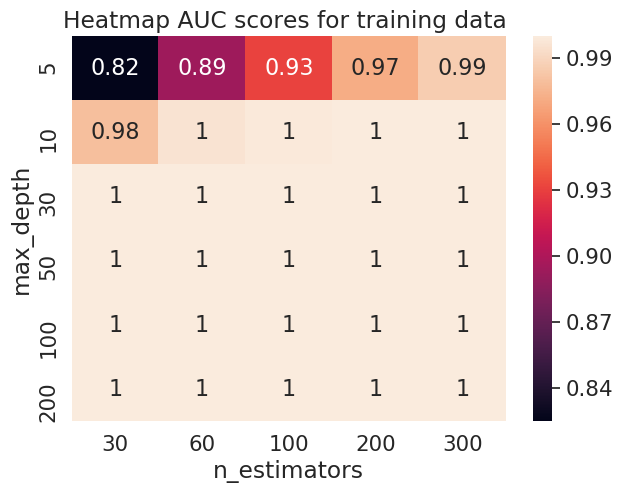

In [20]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
  
df_cm = pd.DataFrame(train_score_reshaped, depth, n_estimators)
plt.figure(figsize = (7, 5))
sn.set(font_scale = 1.4) #for label size
df_cm.index.name = 'max_depth'
df_cm.columns.name = 'n_estimators'
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2g')# font size
plt.title("Heatmap AUC scores for training data ")

Text(0.5, 1, 'Heatmap AUC scores for cross validation data')

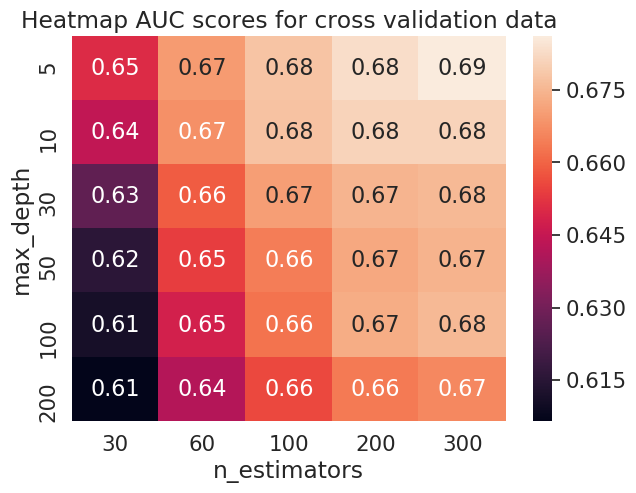

In [21]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
  
df_cm = pd.DataFrame(cv_score_reshaped, depth, n_estimators)
plt.figure(figsize = (7, 5))
sn.set(font_scale = 1.4) #for label size
df_cm.index.name = 'max_depth'
df_cm.columns.name = 'n_estimators'
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2g')# font size
plt.title("Heatmap AUC scores for cross validation data")

#### We get best hyperparameters as max_depth = 2 and n_estimaters = 30 for which AUC value for cross validation data and Train data is balanced

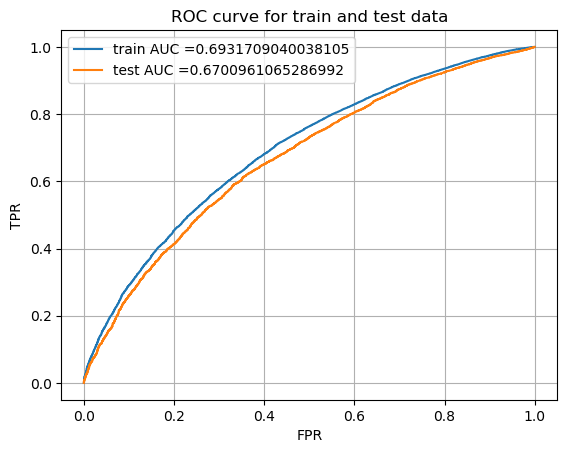

In [56]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
from sklearn.metrics import roc_auc_score
import xgboost as xgb

clf = xgb.XGBClassifier(random_state=42, max_depth = 2, n_estimaters = 30, n_jobs=-1)

clf.fit(X_tr, y_train)

y_train_pred = clf.predict_proba(X_tr)[:,1]
y_test_pred = clf.predict_proba(X_te)[:,1]


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for train and test data")
plt.grid()
plt.show()

##### Drawing confusion matrix

In [57]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
# this function returns actual prediction in form of 0 and 1 by accepting the probability score on the data
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [58]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
cmtr = confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr))
print("Test confusion matrix")
cmte = confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.41109050717617235 for threshold 0.837
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.39616956086622906 for threshold 0.89


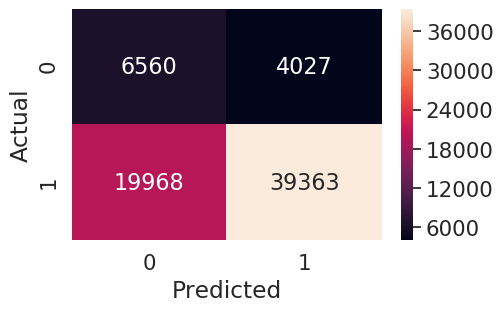

In [59]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
array = cmtr       
df_cm = pd.DataFrame(array, range(2),range(2))
plt.figure(figsize = (5,3))
sn.set(font_scale=1.4) #for label size
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
plt.show()

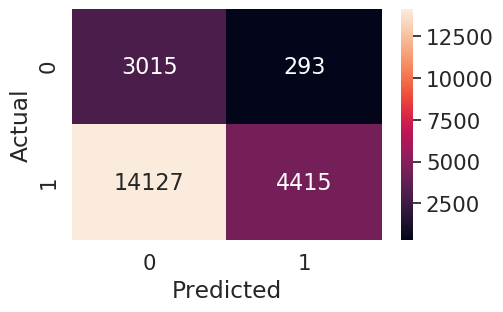

In [60]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
array = cmte       
df_cm = pd.DataFrame(array, range(2),range(2))
plt.figure(figsize = (5,3))
sn.set(font_scale=1.4) #for label size
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
plt.show()

### 2.5.2 Applying XGBOOST on TFIDF ,<font color='red'> SET 2</font>

In [61]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_tfidf, X_train_title_tfidf, X_train_state_ohe, X_train_categories_ohe, X_train_subcategories_ohe, X_train_teacher_prefix_ohe, X_train_pgc_ohe, X_train_price_norm, X_train_tnppp_norm)).tocsr()
X_cr = hstack((X_cv_essay_tfidf, X_cv_title_tfidf, X_cv_state_ohe, X_cv_categories_ohe, X_cv_subcategories_ohe, X_cv_teacher_prefix_ohe, X_cv_pgc_ohe, X_cv_price_norm, X_cv_tnppp_norm)).tocsr()
X_te = hstack((X_test_essay_tfidf, X_test_title_tfidf, X_test_state_ohe, X_test_categories_ohe, X_test_subcategories_ohe, X_test_teacher_prefix_ohe, X_test_pgc_ohe, X_test_price_norm, X_test_tnppp_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(69918, 7465) (69918,)
(17480, 7465) (17480,)
(21850, 7465) (21850,)


In [62]:
# Since hyperparameters tuning takes too long on complete training data so we are 
# using only 5000 data points for hyperparameters tuning.
X_tr_new = X_tr[:5000]
y_train_new = y_train[:5000]
print(X_tr_new.shape, y_train_new.shape)

(5000, 7465) (5000,)


<i> Hyperparameter tunning using gridsearchcv </i>

In [33]:
# importing required libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import seaborn as sns
import numpy as np

# our hyperparameters to choose from
depth = [5, 10, 30, 50, 100]
n_estimators = [50, 100, 200, 300]
param_grid = dict(max_depth = depth, n_estimators = n_estimators)

xgb_model = xgb.XGBClassifier(random_state=42, n_jobs=3)

clf = GridSearchCV(xgb_model, param_grid, scoring = 'roc_auc', cv=3, n_jobs = -1, return_train_score=True)

sc = clf.fit(X_tr_new, y_train_new)

# getting all the results
scores = clf.cv_results_
# getting train scores and cross validation scores
train_score = scores['mean_train_score']
cv_score = scores['mean_test_score']
 
# Reshape matrix for printing out in heatmap
train_score_reshaped = train_score.reshape(len(depth), len(n_estimators))
cv_score_reshaped = cv_score.reshape(len(depth), len(n_estimators))

Text(0.5, 1, 'Heatmap AUC scores for training data ')

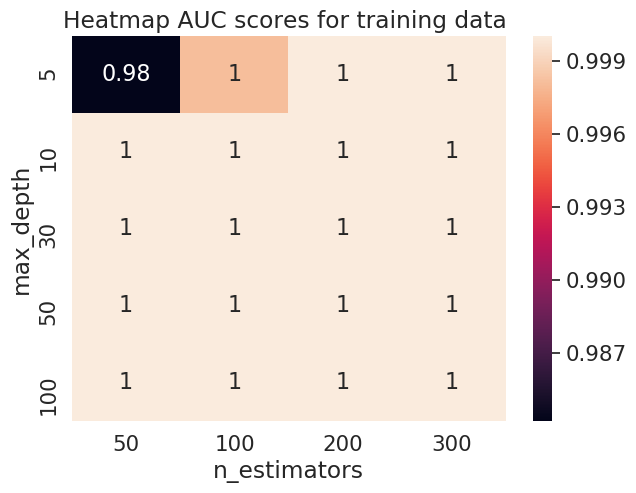

In [34]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
  
df_cm = pd.DataFrame(train_score_reshaped, depth, n_estimators)
plt.figure(figsize = (7, 5))
sn.set(font_scale = 1.4) #for label size
df_cm.index.name = 'max_depth'
df_cm.columns.name = 'n_estimators'
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2g')# font size
plt.title("Heatmap AUC scores for training data ")

Text(0.5, 1, 'Heatmap AUC scores for cross validation data')

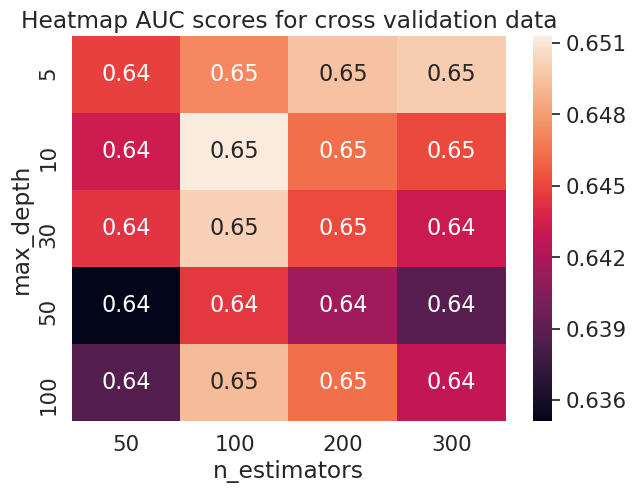

In [35]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
  
df_cm = pd.DataFrame(cv_score_reshaped, depth, n_estimators)
plt.figure(figsize = (7, 5))
sn.set(font_scale = 1.4) #for label size
df_cm.index.name = 'max_depth'
df_cm.columns.name = 'n_estimators'
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2g')# font size
plt.title("Heatmap AUC scores for cross validation data")

<strong>We get optimal hyperparameters as max_depth = 3 and n_estimaters = 15 for which AUC value is optimal </strong>

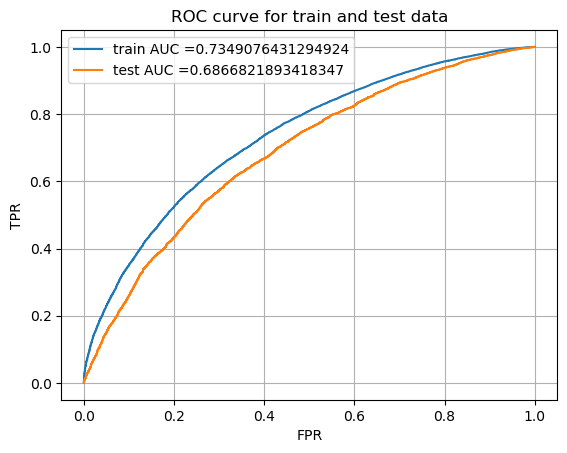

In [68]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
from sklearn.metrics import roc_auc_score
import xgboost as xgb

clf = xgb.XGBClassifier(class_weight='balanced', random_state=42, max_depth = 3, n_estimaters = 15, n_jobs=-1)

clf.fit(X_tr, y_train)

y_train_pred = clf.predict_proba(X_tr)[:,1]
y_test_pred = clf.predict_proba(X_te)[:,1]


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for train and test data")
plt.grid()
plt.show()

##### Drawing confusion matrix

In [69]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
# this function returns actual prediction in form of 0 and 1 by accepting the probability score on the data
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [70]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
cmtr = confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr))
print("Test confusion matrix")
cmte = confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.45205049334938635 for threshold 0.843
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.40866061519603786 for threshold 0.896


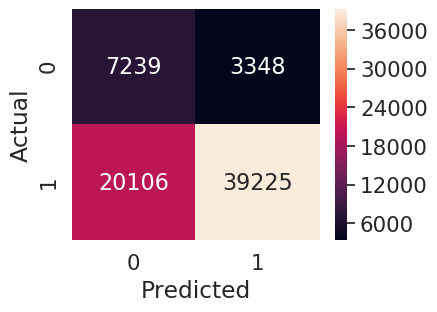

In [71]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = cmtr       
df_cm = pd.DataFrame(array, range(2),range(2))
plt.figure(figsize = (4,3))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sn.set(font_scale=1.4) #for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
plt.show()

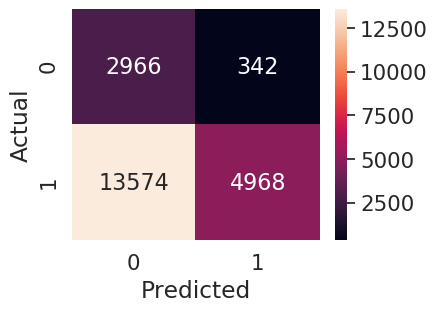

In [72]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = cmte       
df_cm = pd.DataFrame(array, range(2),range(2))
plt.figure(figsize = (4,3))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sn.set(font_scale=1.4) #for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
plt.show()

### 2.5.3 Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

In [73]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_avgw2v, X_train_title_avgw2v, X_train_state_ohe, X_train_categories_ohe, X_train_subcategories_ohe, X_train_teacher_prefix_ohe, X_train_pgc_ohe, X_train_price_norm, X_train_tnppp_norm)).tocsr()
X_cr = hstack((X_cv_essay_avgw2v, X_cv_title_avgw2v, X_cv_state_ohe, X_cv_categories_ohe, X_cv_subcategories_ohe, X_cv_teacher_prefix_ohe, X_cv_pgc_ohe, X_cv_price_norm, X_cv_tnppp_norm)).tocsr()
X_te = hstack((X_test_essay_avgw2v, X_test_title_avgw2v, X_test_state_ohe, X_test_categories_ohe, X_test_subcategories_ohe, X_test_teacher_prefix_ohe, X_test_pgc_ohe, X_test_price_norm, X_test_tnppp_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(69918, 612) (69918,)
(17480, 612) (17480,)
(21850, 612) (21850,)


In [51]:
# Since hyperparameters tuning takes too long so we are 
# using only 5000 data points for hyperparameters tuning
X_tr_new = X_tr[:5000]
y_train_new = y_train[:5000]
print(X_tr_new.shape, y_train_new.shape)

(5000, 612) (5000,)


In [52]:
# importing required libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import seaborn as sns
import numpy as np

# our hyperparameters to choose from
depth = [2, 5, 10, 30, 60]
n_estimators = [30, 50, 100, 200]
param_grid = dict(max_depth = depth, n_estimators = n_estimators)

xgb_model = xgb.XGBClassifier(random_state=42, n_jobs=3)

clf = GridSearchCV(xgb_model, param_grid, scoring = 'roc_auc', cv=3, n_jobs = -1, return_train_score=True)

sc = clf.fit(X_tr_new, y_train_new)

# getting all the results
scores = clf.cv_results_
# getting train scores and cross validation scores
train_score = scores['mean_train_score']
cv_score = scores['mean_test_score']
 
# Reshape matrix for printing out in heatmap
train_score_reshaped = train_score.reshape(len(depth), len(n_estimators))
cv_score_reshaped = cv_score.reshape(len(depth), len(n_estimators))

Text(0.5, 1, 'Heatmap AUC scores for training data ')

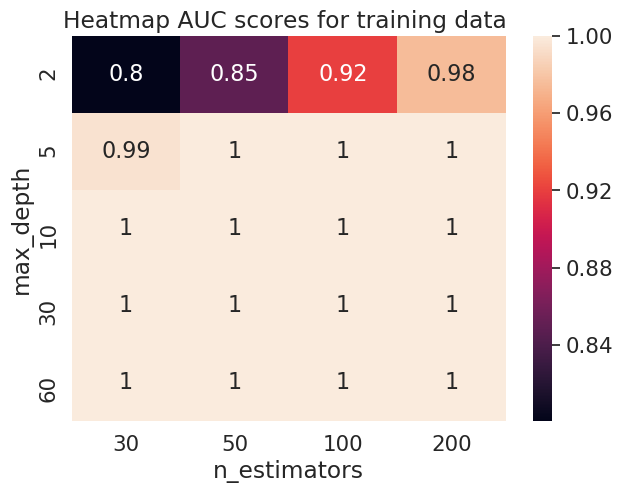

In [53]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
  
df_cm = pd.DataFrame(train_score_reshaped, depth, n_estimators)
plt.figure(figsize = (7, 5))
sn.set(font_scale = 1.4) #for label size
df_cm.index.name = 'max_depth'
df_cm.columns.name = 'n_estimators'
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2g')# font size
plt.title("Heatmap AUC scores for training data ")

Text(0.5, 1, 'Heatmap AUC scores for cross validation data')

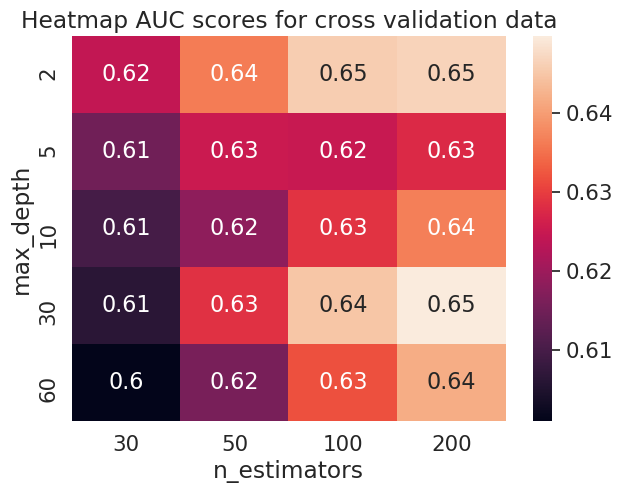

In [54]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
  
df_cm = pd.DataFrame(cv_score_reshaped, depth, n_estimators)
plt.figure(figsize = (7, 5))
sn.set(font_scale = 1.4) #for label size
df_cm.index.name = 'max_depth'
df_cm.columns.name = 'n_estimators'
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2g')# font size
plt.title("Heatmap AUC scores for cross validation data")

<i>We train model for hyperparameters as max_depth = 2 and n_estimaters = 15 for which AUC value is optimal</i>

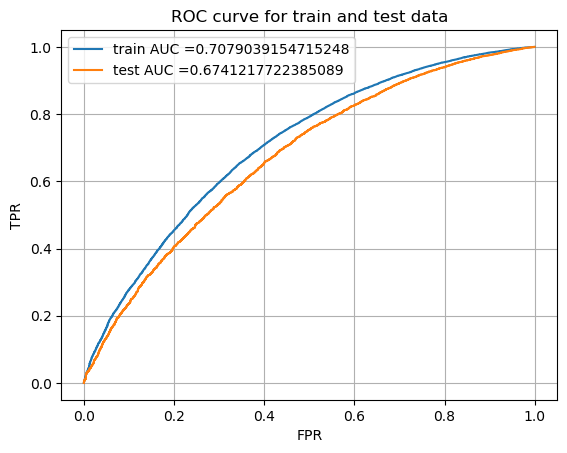

In [75]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
from sklearn.metrics import roc_auc_score
import xgboost as xgb

clf = xgb.XGBClassifier(class_weight='balanced', random_state = 42, max_depth = 2, n_estimaters = 15, n_jobs=-1)

clf.fit(X_tr, y_train)

y_train_pred = clf.predict_proba(X_tr)[:,1]
y_test_pred = clf.predict_proba(X_te)[:,1]


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for train and test data")
plt.grid()
plt.show()

##### Drawing confusion matrix

In [76]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
# this function returns actual prediction in form of 0 and 1 by accepting the probability score on the data
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [77]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
cmtr = confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr))
print("Test confusion matrix")
cmte = confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.4280406772279278 for threshold 0.847
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.39379616223412267 for threshold 0.897


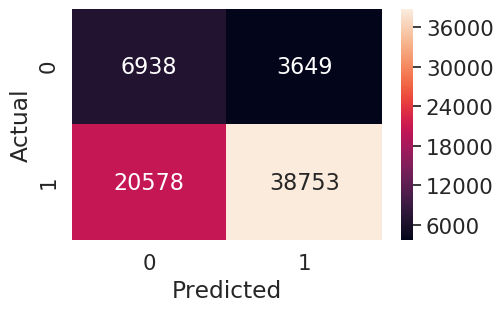

In [78]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
array = cmtr       
df_cm = pd.DataFrame(array, range(2),range(2))
plt.figure(figsize = (5,3))
sn.set(font_scale=1.4) #for label size
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
plt.show()

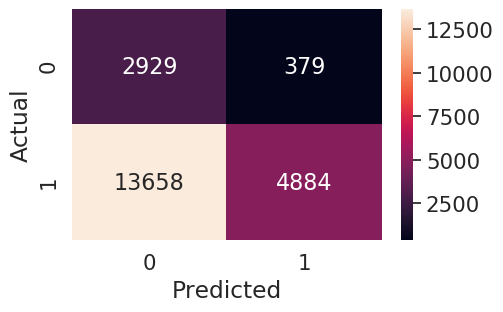

In [79]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
array = cmte       
df_cm = pd.DataFrame(array, range(2),range(2))
plt.figure(figsize = (5,3))
sn.set(font_scale=1.4) #for label size
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
plt.show()

### 2.5.4 Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

In [80]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_tww2v, X_train_titles_tww2v, X_train_state_ohe, X_train_categories_ohe, X_train_subcategories_ohe, X_train_teacher_prefix_ohe, X_train_pgc_ohe, X_train_price_norm, X_train_tnppp_norm)).tocsr()
X_cr = hstack((X_cv_essay_tww2v, X_cv_titles_tww2v, X_cv_state_ohe, X_cv_categories_ohe, X_cv_subcategories_ohe, X_cv_teacher_prefix_ohe, X_cv_pgc_ohe, X_cv_price_norm, X_cv_tnppp_norm)).tocsr()
X_te = hstack((X_test_essay_tww2v, X_test_titles_tww2v, X_test_state_ohe, X_test_categories_ohe, X_test_subcategories_ohe, X_test_teacher_prefix_ohe, X_test_pgc_ohe, X_test_price_norm, X_test_tnppp_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(69918, 612) (69918,)
(17480, 612) (17480,)
(21850, 612) (21850,)


In [62]:
# Since hyperparameters tuning takes too long on complete dataset so we are 
# using only 5000 data points for hyperparameters tuning
X_tr_new = X_tr[:5000]
y_train_new = y_train[:5000]
print(X_tr_new.shape, y_train_new.shape)

(5000, 612) (5000,)


In [63]:
# importing required libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import seaborn as sns
import numpy as np

# our hyperparameters to choose from
depth = [2, 5, 10, 30, 60]
n_estimators = [30, 50, 100, 200]
param_grid = dict(max_depth = depth, n_estimators = n_estimators)

xgb_model = xgb.XGBClassifier(random_state=42, n_jobs=3)

clf = GridSearchCV(xgb_model, param_grid, scoring = 'roc_auc', cv=3, n_jobs = -1, return_train_score=True)

sc = clf.fit(X_tr_new, y_train_new)

# getting all the results
scores = clf.cv_results_
# getting train scores and cross validation scores
train_score = scores['mean_train_score']
cv_score = scores['mean_test_score']
 
# Reshape matrix for printing out in heatmap
train_score_reshaped = train_score.reshape(len(depth), len(n_estimators))
cv_score_reshaped = cv_score.reshape(len(depth), len(n_estimators))

Text(0.5, 1, 'Heatmap AUC scores for training data ')

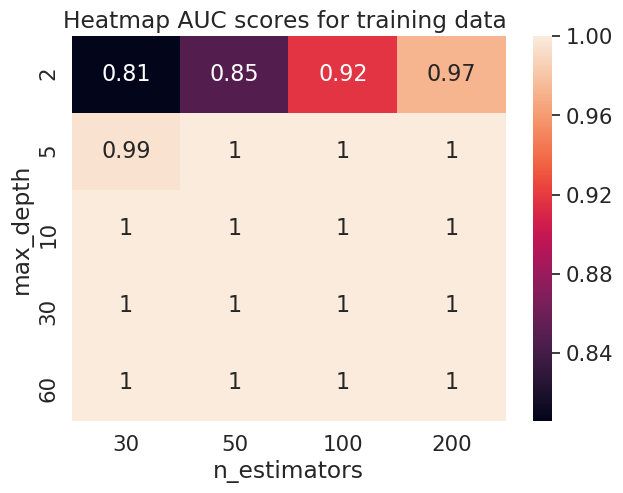

In [64]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
  
df_cm = pd.DataFrame(train_score_reshaped, depth, n_estimators)
plt.figure(figsize = (7, 5))
sn.set(font_scale = 1.4) #for label size
df_cm.index.name = 'max_depth'
df_cm.columns.name = 'n_estimators'
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2g')# font size
plt.title("Heatmap AUC scores for training data ")

Text(0.5, 1, 'Heatmap AUC scores for cross validation data')

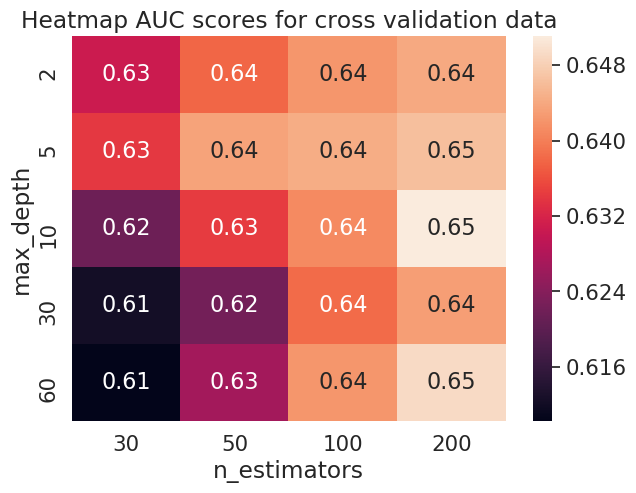

In [65]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
  
df_cm = pd.DataFrame(cv_score_reshaped, depth, n_estimators)
plt.figure(figsize = (7, 5))
sn.set(font_scale = 1.4) #for label size
df_cm.index.name = 'max_depth'
df_cm.columns.name = 'n_estimators'
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2g')# font size
plt.title("Heatmap AUC scores for cross validation data")

<i>We get optimal hyperparameters as max_depth = 2 and n_estimaters = 15. </i>

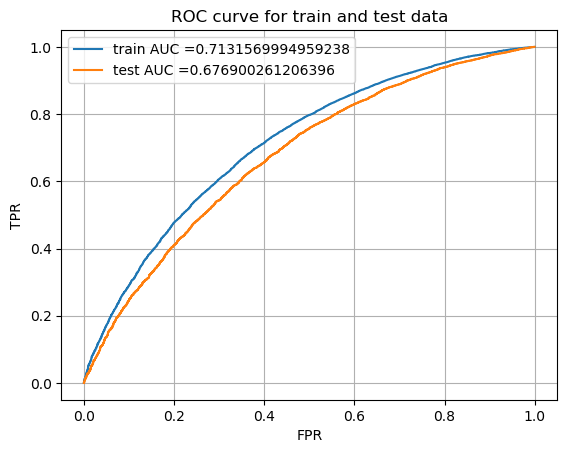

In [82]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
from sklearn.metrics import roc_auc_score
import xgboost as xgb

clf = xgb.XGBClassifier(random_state=42, max_depth = 2, n_estimaters = 15, n_jobs=-1)

clf.fit(X_tr, y_train)

y_train_pred = clf.predict_proba(X_tr)[:,1]
y_test_pred = clf.predict_proba(X_te)[:,1]


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for train and test data")
plt.grid()
plt.show()

##### Drawing confusion matrix

In [83]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
# this function returns actual prediction in form of 0 and 1 by accepting the probability score on the data
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

#### Drawing confusion matrix

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
By definition a confusion matrix  is such that  is equal to the number of observations known to be in group  but predicted to be in group .

Thus in binary classification, the count of true negatives is C00, false negatives is C10, true positives is C01 and false positives is C01.

In [84]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
cmtr = confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr))
print("Test confusion matrix")
cmte = confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.43346423353682817 for threshold 0.838
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.3976712335288479 for threshold 0.901


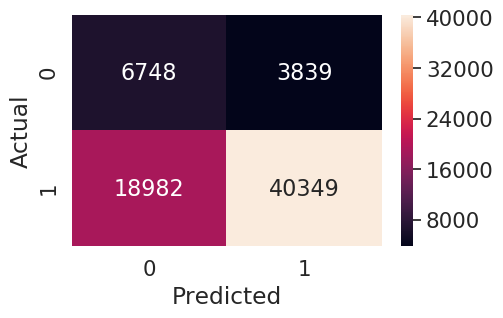

In [85]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
array = cmtr       
df_cm = pd.DataFrame(array, range(2),range(2))
plt.figure(figsize = (5,3))
sn.set(font_scale=1.4) #for label size
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
plt.show()

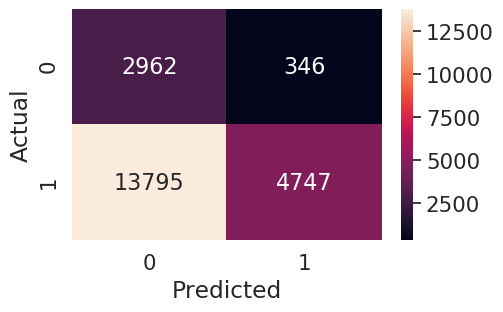

In [86]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
array = cmte       
df_cm = pd.DataFrame(array, range(2),range(2))
plt.figure(figsize = (5,3))
sn.set(font_scale=1.4) #for label size
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
plt.show()

<h1>3. Conclusion</h1>

In [96]:
# compare models using Prettytable library
# source http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizor", "Model", "max_depth","n_estimaters", "AUC"]

x.add_row(["BOW", "RandomForest", 5, 200, 0.67])
x.add_row(["TFIDF", "RandomForest", 5, 60, 0.66])
x.add_row(["W2V", "RandomForest", 5, 50, 0.66])
x.add_row(["TFIDFW2V", "RandomForest", 3, 60, 0.65])
x.add_row(["--------", "---------", 000, 000, 000])
x.add_row(["BOW", "GBDT", 2, 30, 0.67])
x.add_row(["TFIDF", "GBDT", 3, 15, 0.68])
x.add_row(["W2V", "GBDT", 2, 15, 0.67])
x.add_row(["TFIDFW2V", "GBDT", 2, 15, 0.67])

print(x)

+------------+--------------+-----------+--------------+------+
| Vectorizor |    Model     | max_depth | n_estimaters | AUC  |
+------------+--------------+-----------+--------------+------+
|    BOW     | RandomForest |     5     |     200      | 0.67 |
|   TFIDF    | RandomForest |     5     |      60      | 0.66 |
|    W2V     | RandomForest |     5     |      50      | 0.66 |
|  TFIDFW2V  | RandomForest |     3     |      60      | 0.65 |
|  --------  |  ---------   |     0     |      0       |  0   |
|    BOW     |     GBDT     |     2     |      30      | 0.67 |
|   TFIDF    |     GBDT     |     3     |      15      | 0.68 |
|    W2V     |     GBDT     |     2     |      15      | 0.67 |
|  TFIDFW2V  |     GBDT     |     2     |      15      | 0.67 |
+------------+--------------+-----------+--------------+------+
